# Inversion of individual Hanle profiles


### Here we will invert a couple of profiles that exhibit Hanle effect signatures. These are kindly provided by David Orozco Suarez. We will also look ast some of the maps observed by the same telescope later. 

In [1]:
import numpy as np 
import hazel 
import matplotlib.pyplot as plt 
import h5py
from astropy.io import fits 

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import matplotlib
font = {'size'   : 18}

matplotlib.rc('font', **font)

In [3]:
# Let's first load a profile:
data = np.loadtxt("/home/milic/data/SP2022/TIP_single_profiles/TIP_single_profiles/profA6.perf",skiprows=1,unpack=True)
data.shape

(9, 91)

In [4]:
ll = np.copy(data[0]) + 10829.09
stokes = np.copy(data[1:5])
noise = np.copy(data[5:])

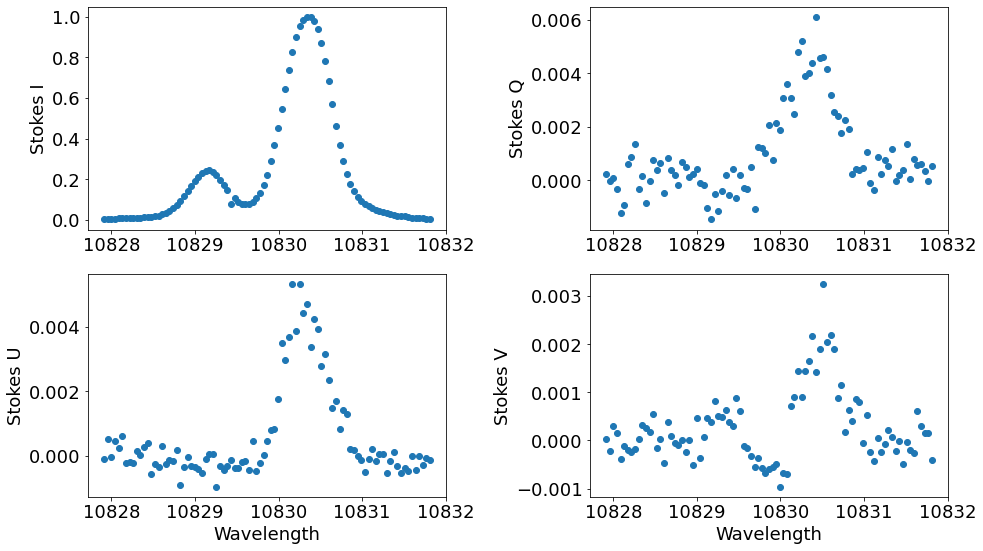

In [5]:
# Let's visualize these profiles: 
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o')
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")
plt.tight_layout()

### We will go straight to the inversion, we know what we need to do! 

In [45]:
# First the wavelength axis
n_wvl = len(ll)
stokes_to_fit = np.copy(stokes)
np.savetxt('10830_A6.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_A6.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

# And finally, the 'observed' Stokes parameters:

# Note, the magical number we are multiplying stokes vector with will become clear soon!

f = open('10830_A6_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 90.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes_to_fit, noise]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()



In [78]:
nrand = 1
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_A6.ini', working_mode='inversion', verbose=2, rank=iterator.get_rank(), randomization=nrand)
iterator.use_model(model=mod)
iterator.run_all_pixels()

2022-09-02 14:02:26,741 - Hazel2 v1.0
2022-09-02 14:02:26,742 - Using configuration from file : conf_A6.ini
2022-09-02 14:02:26,745 - Backtracking mode : brent
2022-09-02 14:02:26,745 - Adding spectral region spec1
2022-09-02 14:02:26,746 -   - Reading wavelength axis from 10830_A6.wavelength
2022-09-02 14:02:26,748 -   - Reading wavelength weights from 10830_A6.weights
2022-09-02 14:02:26,750 -   - Using observations from 10830_A6_stokes.1d
2022-09-02 14:02:26,751 -   - No mask for pixels
2022-09-02 14:02:26,752 -   - No instrumental profile
2022-09-02 14:02:26,752 -   - Using default boundary conditions [1,0,0,0] in spectral region spec1 or read from file. Check carefully!
2022-09-02 14:02:26,754 - Using 3 cycles
2022-09-02 14:02:26,755 - Using analytical RFs if possible : False
2022-09-02 14:02:26,756 - Using 30 max. iterations
2022-09-02 14:02:26,757 - Not using randomizations
2022-09-02 14:02:26,758 - Stopping when relative error is below 0.001
2022-09-02 14:02:26,759 - Saving all

100%|██████████| 1/1 [00:15<00:00, 16.00s/it]


In [79]:
result = h5py.File('outputA6.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(nrand,4,n_wvl)
fit.shape

(1, 4, 91)

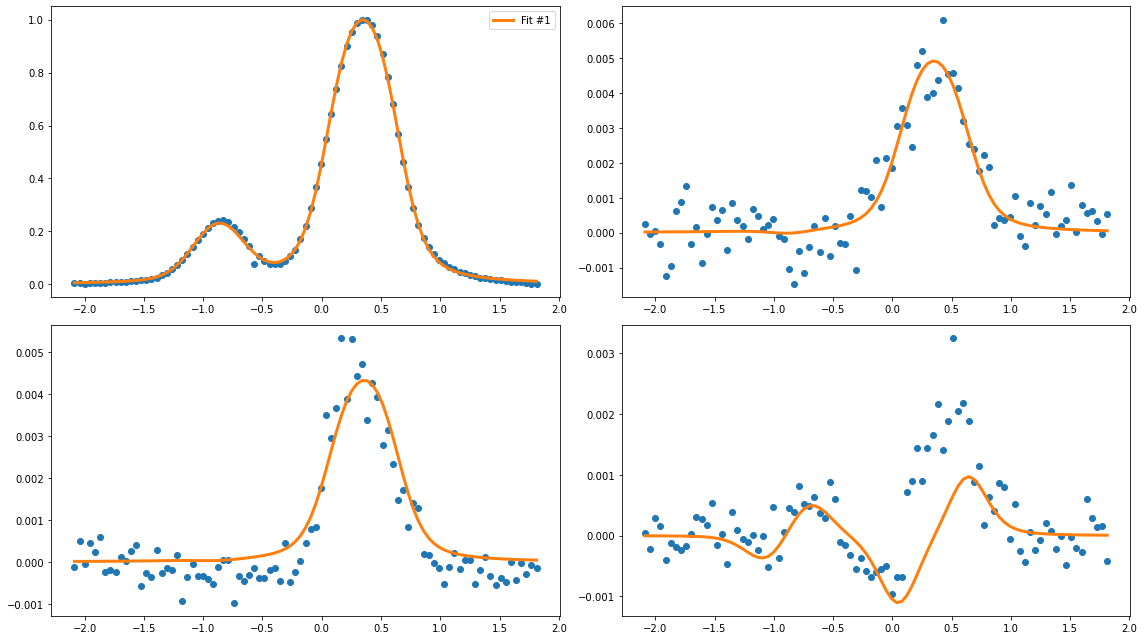

In [81]:
plt.figure(figsize=[16,9])
plt.subplot(221)
plt.plot(ll-10830,stokes_to_fit[0,:],'o')
for i in range(0,1):
    plt.plot(ll-10830,fit[i,0,:], linewidth=3, label = 'Fit #'+str(i+1))

plt.legend()
plt.subplot(222)
plt.plot(ll-10830,stokes_to_fit[1,:],'o')
for i in range(0,1):
    plt.plot(ll-10830,fit[i,1,:], linewidth=3, label = 'Fit #'+str(i+1))

plt.subplot(223)
plt.plot(ll-10830,stokes_to_fit[2,:],'o')
for i in range(0,1):
    plt.plot(ll-10830,fit[i,2,:], linewidth=3, label = 'Fit #'+str(i+1))

plt.subplot(224)
plt.plot(ll-10830,stokes_to_fit[3,:],'o')
for i in range(0,1):
    plt.plot(ll-10830,fit[i,3,:], linewidth=3, label = 'Fit #'+str(i+1))


In [77]:
%rm outputA6.h5

In [70]:
print(result['spec1']['chi2'][0,:,-1])
print(result['spec1']['chi2'][0].shape)

[0.43300289 0.3269943  0.27667982 0.27667305 0.27667633]
(5, 3)


In [72]:
good = [2,3,4]


In [73]:
result['ch1'].keys()
# Print them neatly:
for i in good:
    print ("----------------------------------")
    print ("Fit # ",i)
    print ("----------------------------------")
    print ("Bx= ",result['ch1']['Bx'][0,i,0])
    print ("By= ",result['ch1']['By'][0,i,0])
    print ("Bz= ",result['ch1']['Bz'][0,i,0])
    print ("tau= ",result['ch1']['tau'][0,i,0])
    print ("vlos ",result['ch1']['v'][0,i,0])
    print ("vtherm= ",result['ch1']['deltav'][0,i,0])
    print ("beta= ",result['ch1']['beta'][0,i,0])
    print ("a= ",result['ch1']['a'][0,i,0])
#result.close()

----------------------------------
Fit #  2
----------------------------------
Bx=  7.340216215447171
By=  3.486796500124214
Bz=  0.8876686498649704
tau=  1.4074027671368998
vlos  1.1289497522001675
vtherm=  7.136658327856395
beta=  1.00000001
a=  0.25656586785124524
----------------------------------
Fit #  3
----------------------------------
Bx=  7.335815542194979
By=  -3.484420450273582
Bz=  -0.8866257375625324
tau=  1.4070656676746056
vlos  1.1288957505175325
vtherm=  7.13806514804182
beta=  1.00000001
a=  0.2563931837788377
----------------------------------
Fit #  4
----------------------------------
Bx=  7.345609316343037
By=  3.4895647866381765
Bz=  0.8887477657767562
tau=  1.4071851859163251
vlos  1.128943108393191
vtherm=  7.137526934522426
beta=  1.00000001
a=  0.2564564445273593


[7.34021622 7.33581554 7.34560932]
[ 3.4867965  -3.48442045  3.48956479]
[ 0.88766865 -0.88662574  0.88874777]


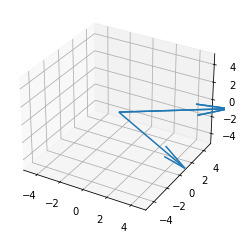

In [74]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

Bx = result['ch1']['Bx'][0,good,0]
By = result['ch1']['By'][0,good,0]
Bz = result['ch1']['Bz'][0,good,0]
print (Bx)
print (By)
print (Bz)

vectors = np.zeros([len(good),6])
for i in range(0,len(good)):
    #vectors[i] = np.array([[0, 0, 0, params_original[0],params_original[1],params_original[2]], [0, 0, 0, Bx,By,Bz]])
    vectors[i] = [0,0,0,Bx[i],By[i],Bz[i]]

X, Y, Z, U, V, W = zip(*vectors)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-5, 5])
plt.show()

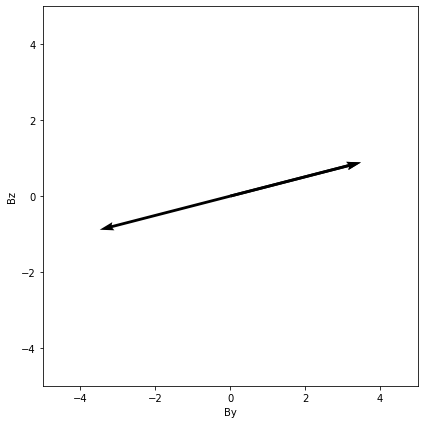

In [76]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

vectors2d = np.zeros([len(good),4])
for i in range(0,len(good)):
    vectors2d[i] = [0,0,By[i],Bz[i]]

X, Y, U, V = zip(*vectors2d)
plt.figure()
ax = plt.gca()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
plt.xlabel("By")
plt.ylabel("Bz")
plt.draw()
plt.show()

### This ambiguity is found by running multiple randomizations! 

We only see 2 ambiguities, where are the other 2? We can try and find them manually! 

How?

We now have solutions in local coordinate system. 

We transform them to the LOS coordinate system, using rotations from Hazel installation page. 

We then find what azimuth is in the LOS coordinate system (capital phi B). 

Then, we pick one solution and find other 3, (+/- pi/2, +pi). 

We transform these new 3 azimuths from LOS coordinate system to local coordinate system. 

Find appopriate Bx, By, Bz. And visualize them. 

In [ ]:
result.close()
%rm output_onepixel.h5

### How to interpret this? Let's look at the observing geometry one more time! 
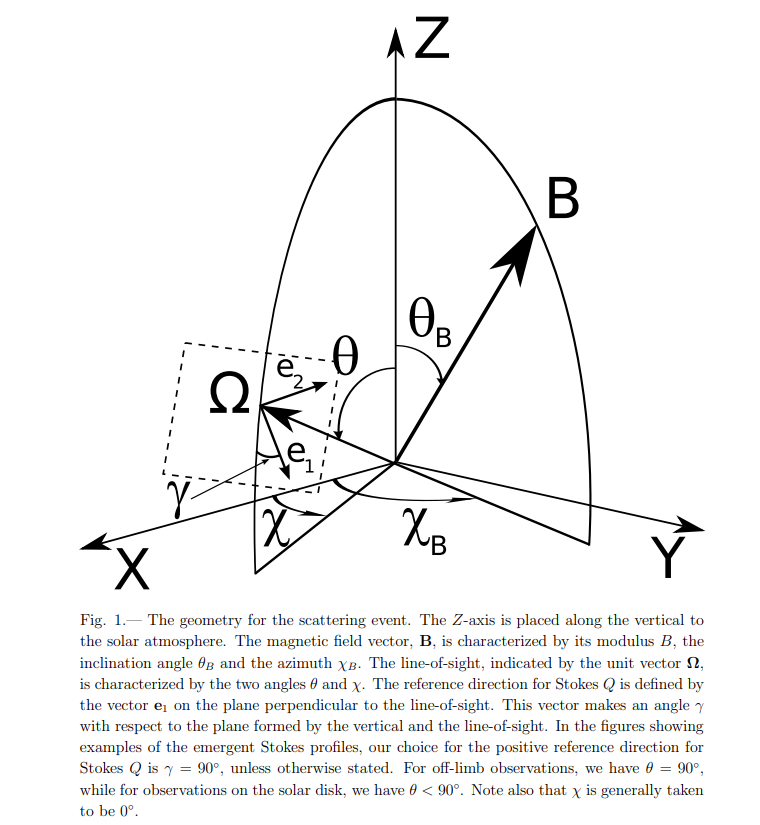

# Now we can try profile 6. This is a prominence, 22" above the limb!

# We can also try out spicule spectra (profiles 8 and 9).

In [ ]:
data = np.loadtxt("profiles/profA8.perf",skiprows=1,unpack=True)
data.shape
ll = np.copy(data[0]) + 10829.09
stokes = np.copy(data[1:5])
noise = np.copy(data[5:])

In [ ]:
data_prom = np.loadtxt("profiles/profA6.perf",skiprows=1,unpack=True)
data_prom.shape
ll_prom = np.copy(data_prom[0]) + 10829.09
stokes_prom = np.copy(data_prom[1:5])
noise_prom = np.copy(data_prom[5:])

In [ ]:
plt.figure(figsize=[14,8])
plt.subplot(221)
plt.plot(ll,stokes[0,:],'o',label='spicule')
plt.plot(ll_prom,stokes_prom[0,:],'o',label='prominence')
plt.legend()
plt.ylabel("Stokes I")
plt.subplot(222)
plt.plot(ll,stokes[1,:],'o')
plt.plot(ll_prom,stokes_prom[1,:],'o')
plt.ylabel("Stokes Q")
plt.subplot(223)
plt.plot(ll,stokes[2,:],'o')
plt.plot(ll_prom,stokes_prom[2,:],'o')
plt.ylabel("Stokes U")
plt.xlabel("Wavelength")
plt.subplot(224)
plt.plot(ll,stokes[3,:],'o')
plt.plot(ll_prom,stokes_prom[3,:],'o')
plt.ylabel("Stokes V")
plt.xlabel("Wavelength")

In [ ]:
# First the wavelength axis
n_wvl = len(ll)
np.savetxt('10830_A8.wavelength', ll, header='lambda')

# Then we will save something called, 'weigths', this will allow us to fine-tune the inversion if needed.
f = open('10830_A8.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_wvl):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()

stokes_to_fit = stokes

# And finally, the 'observed' Stokes parameters:

f = open('10830_A8_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 90.0\n') # This should be identical to the above otherwise we will get inconsistent results. 
                            # this is something you should know from the observations
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes_to_fit, noise]) # the second one only adds appropriate noise next to each Stokes
                                                        # measurement
np.savetxt(f, tmp.T)
f.close()


In [ ]:
iterator = hazel.Iterator(use_mpi=False)
mod = hazel.Model('conf_test_A8.ini', working_mode='inversion', verbose=1, rank=iterator.get_rank(), randomization=20)
iterator.use_model(model=mod)
iterator.run_all_pixels()

In [ ]:
result = h5py.File('output_onepixel.h5','r')
fit = np.copy(result['spec1']['stokes'])
fit = fit.reshape(20,4,n_wvl)
fit.shape

In [ ]:
plt.figure(figsize=[8,5])
r = 0
plt.subplot(221)
plt.plot(ll-10830,stokes_to_fit[0,:],'o')
for r in range(0,20):
    plt.plot(ll-10830,fit[r,0,:])
plt.subplot(222)
plt.plot(ll-10830,stokes_to_fit[1,:],'o')
for r in range(0,20):
    plt.plot(ll-10830,fit[r,1,:])
plt.subplot(223)
plt.plot(ll-10830,stokes_to_fit[2,:],'o')
for r in range(0,20):
    plt.plot(ll-10830,fit[r,2,:])
plt.subplot(224)
plt.plot(ll-10830,stokes_to_fit[3,:],'o')
for r in range(0,20):
    plt.plot(ll-10830,fit[r,3,:])

In [ ]:
print (result['spec1']['chi2'][0,:,1])

In [ ]:
good = np.array([0,1,2,3,4,5,7,8,9,10,12,13,14,15,16,17,18,19])

In [ ]:
result['ch1']['Bx'].shape

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

Bx = result['ch1']['Bx'][0,good,0]
By = result['ch1']['By'][0,good,0]
Bz = result['ch1']['Bz'][0,good,0]
print (Bx)
print (By)
print (Bz)

vectors = np.zeros([len(good),6])
for i in range(0,len(good)):
    #vectors[i] = np.array([[0, 0, 0, params_original[0],params_original[1],params_original[2]], [0, 0, 0, Bx,By,Bz]])
    vectors[i] = [0,0,0,Bx[i],By[i],Bz[i]]

X, Y, Z, U, V, W = zip(*vectors)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_zlim([-20, 20])
plt.show()

## Let's plot these vectors in the plane of the sky! 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [6, 6]
plt.rcParams["figure.autolayout"] = True

vectors2d = np.zeros([len(good),4])
for i in range(0,len(good)):
    vectors2d[i] = [0,0,By[i],Bz[i]]

X, Y, U, V = zip(*vectors2d)
plt.figure()
ax = plt.gca()
ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
plt.xlabel("By")
plt.ylabel("Bz")
plt.draw()
plt.show()

In [ ]:
result['ch1'].keys()
# Print them neatly:
print ("Bx= ",result['ch1']['Bx'][0,0,0])
print ("By= ",result['ch1']['By'][0,0,0])
print ("Bz= ",result['ch1']['Bz'][0,0,0])
print ("tau= ",result['ch1']['tau'][0,0,0])
print ("vlos ",result['ch1']['v'][0,0,0])
print ("vtherm= ",result['ch1']['deltav'][0,0,0])
print ("a= ",result['ch1']['a'][0,0,0])
result.close()

In [ ]:
%rm output_onepixel.h5

## "And you're always going to come back to this picture...." How is the magnetic field looking like? 

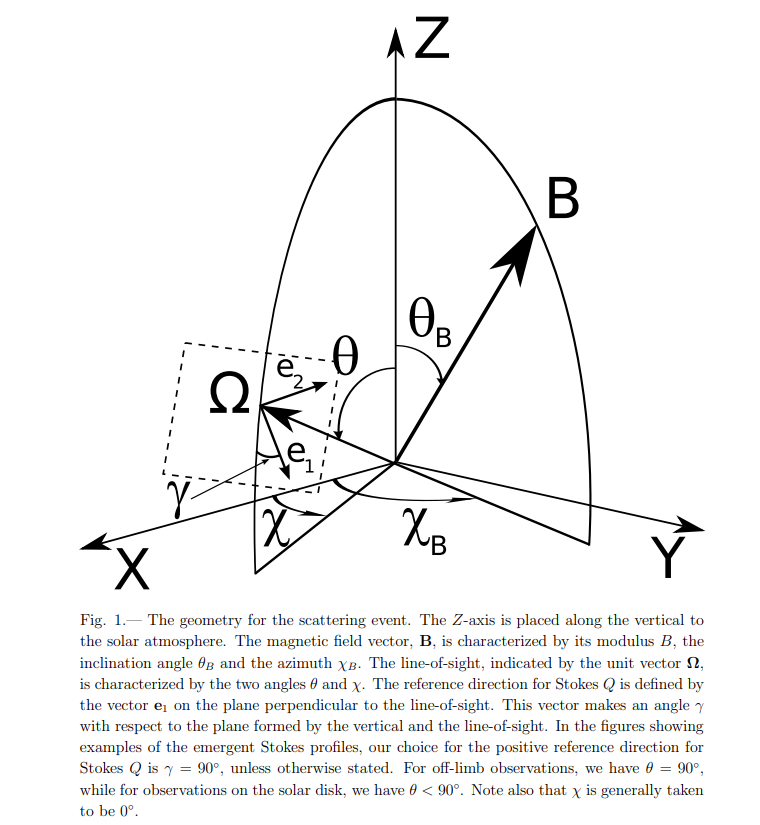